In [ ]:
## From utils.py
import os

import torch
from cv2 import imread
import numpy as np
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

def get_flying_chairs_data_paths(root: str):
    """
    :param root: the absolute path to where dataset is located (<sample_id>_img1.ppm <sample_id>_img2.ppm <sample_id>_flow.flo)
    """

    samples = []
    for name in sorted(os.listdir(root)):
        if name.endswith('_flow.flo'):
            sample_id = name[: -9]
            img1 = os.path.join(root, sample_id + "_img1.ppm")
            img2 = os.path.join(root, sample_id + "_img2.ppm")
            flow = os.path.join(root, name)
            samples.append([[img1, img2], flow])

    return samples


def flying_chairs_loader(sample):
    inputs, target = sample[0], sample[1]
    img1, img2 = imread(inputs[0]).astype(float) , imread(inputs[1]).astype(float)

    with open(target, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        assert (202021.25 == magic), 'Magic number incorrect. Invalid .flo file'
        h = np.fromfile(f, np.int32, count=1)[0]
        w = np.fromfile(f, np.int32, count=1)[0]
        data = np.fromfile(f, np.float32, count=2 * w * h)
    # Reshape data into 3D array (columns, rows, bands)
    data2D = np.resize(data, (w, h, 2))
    return [img1, img2], data2D


def make_dataset_split(dataset: [], split: float = 0.8, random_seed: int = 42):
    num_train_samples = int(len(dataset) * split)
    num_val_samples = len(dataset) - num_train_samples

    seed = torch.Generator().manual_seed(random_seed)
    return data.random_split(dataset, [num_train_samples, num_val_samples], generator=seed)


def mean_epe(input_flow, target_flow):
    return torch.norm(target_flow - input_flow, p=2, dim=1).mean()


In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torchvision.transforms import v2
from PIL import Image
import torch.nn.functional as F
from torchvision.utils import flow_to_image

In [ ]:
# From loader.py
from typing import Callable, Optional
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, file_names: [str],
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 loader=flying_chairs_loader
                 ):
        """
        Initialized the custom datasets
        :param file_names: list of absolute paths to samples along with path to their targets
        :param transform: transformation for inputs
        :param target_transform: transformation for target
        :param loader: a helper function to read the inputs and targets into numpy array
        """
        self.file_names = file_names
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, idx):
        """
        will return the sample with index idx from the dataset
        :param idx: the index of the sample which will be returned
        :return: input, target pair
        """
        inputs, target = self.loader(self.file_names[idx])
        # apply the transforms and target transform in case they exist
        if self.transform:
            inputs[0] = self.transform(inputs[0])
            inputs[1] = self.transform(inputs[1])
        if self.target_transform:
            target = self.target_transform(target)
        return torch.cat((inputs[0],inputs[1])).float(), target

    def __len__(self):
        """
        will return the total number of samples in the dataset.
        :return: number of samples in the dataset
        """
        return len(self.file_names)

In [ ]:
import time
from tqdm import tqdm

# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [20]:
TRAIN_DATASET_PATH = '/content/gdrive/MyDrive/CVLab6/dataset/train'
TEST_DATASET_PATH = '/content/gdrive/MyDrive/CVLab6/dataset/test'

In [21]:
train_data_pathes = get_flying_chairs_data_paths(TRAIN_DATASET_PATH)
test_data_pathes = get_flying_chairs_data_paths(TEST_DATASET_PATH)

In [22]:
len(test_data_pathes)

165

In [23]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.ToPILImage(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(25),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_target_transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
train_dataset = CustomDataset(train_data_pathes, transform=train_transform, target_transform=train_target_transform)

In [24]:
test_dataset = CustomDataset(test_data_pathes, transform=train_transform, target_transform=train_target_transform)

In [ ]:
train_val_dataset = make_dataset_split(train_dataset)

In [ ]:
#dataloader
batch_size = 16

train_loader = DataLoader(train_val_dataset[0], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_val_dataset[1], batch_size=batch_size, shuffle=True)

In [25]:
test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=True)

In [ ]:
batch_example = next(iter(train_loader))

KeyboardInterrupt: ignored

In [ ]:
batch_example[1].size()

torch.Size([16, 2, 384, 512])

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

def conv(batchNorm, in_planes, out_planes, kernel_size=3, stride=1):
    if batchNorm:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(0.1,inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=True),
            nn.LeakyReLU(0.1,inplace=True)
        )


def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=False)


def deconv(in_planes, out_planes):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.1,inplace=True)
    )

def crop_like(input, target):
    if input.size()[2:] == target.size()[2:]:
        return input
    else:
        return input[:, :, :target.size(2), :target.size(3)]

In [ ]:
from torch.nn.init import kaiming_normal_, constant_

class FlowNetS(nn.Module):
    expansion = 1

    def __init__(self,batchNorm=True):
        super(FlowNetS,self).__init__()

        self.batchNorm = batchNorm
        self.conv1   = conv(self.batchNorm,   6,   64, kernel_size=7, stride=2)
        self.conv2   = conv(self.batchNorm,  64,  128, kernel_size=5, stride=2)
        self.conv3   = conv(self.batchNorm, 128,  256, kernel_size=5, stride=2)
        self.conv3_1 = conv(self.batchNorm, 256,  256)
        self.conv4   = conv(self.batchNorm, 256,  512, stride=2)
        self.conv4_1 = conv(self.batchNorm, 512,  512)
        self.conv5   = conv(self.batchNorm, 512,  512, stride=2)
        self.conv5_1 = conv(self.batchNorm, 512,  512)
        self.conv6   = conv(self.batchNorm, 512, 1024, stride=2)
        self.conv6_1 = conv(self.batchNorm,1024, 1024)

        self.deconv5 = deconv(1024,512)
        self.deconv4 = deconv(1026,256)
        self.deconv3 = deconv(770,128)
        self.deconv2 = deconv(386,64)

        self.predict_flow6 = predict_flow(1024)
        self.predict_flow5 = predict_flow(1026)
        self.predict_flow4 = predict_flow(770)
        self.predict_flow3 = predict_flow(386)
        self.predict_flow2 = predict_flow(194)

        self.upsampled_flow6_to_5 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                kaiming_normal_(m.weight, 0.1)
                if m.bias is not None:
                    constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                constant_(m.weight, 1)
                constant_(m.bias, 0)

    def forward(self, x):
        out_conv2 = self.conv2(self.conv1(x))
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))

        flow6       = self.predict_flow6(out_conv6)
        flow6_up    = crop_like(self.upsampled_flow6_to_5(flow6), out_conv5)
        out_deconv5 = crop_like(self.deconv5(out_conv6), out_conv5)

        concat5 = torch.cat((out_conv5,out_deconv5,flow6_up),1)
        flow5       = self.predict_flow5(concat5)
        flow5_up    = crop_like(self.upsampled_flow5_to_4(flow5), out_conv4)
        out_deconv4 = crop_like(self.deconv4(concat5), out_conv4)

        concat4 = torch.cat((out_conv4,out_deconv4,flow5_up),1)
        flow4       = self.predict_flow4(concat4)
        flow4_up    = crop_like(self.upsampled_flow4_to_3(flow4), out_conv3)
        out_deconv3 = crop_like(self.deconv3(concat4), out_conv3)

        concat3 = torch.cat((out_conv3,out_deconv3,flow4_up),1)
        flow3       = self.predict_flow3(concat3)
        flow3_up    = crop_like(self.upsampled_flow3_to_2(flow3), out_conv2)
        out_deconv2 = crop_like(self.deconv2(concat3), out_conv2)

        concat2 = torch.cat((out_conv2,out_deconv2,flow3_up),1)
        flow2 = self.predict_flow2(concat2)

        if self.training:
            return flow2,flow3,flow4,flow5,flow6
        else:
            return flow2

    def weight_parameters(self):
        return [param for name, param in self.named_parameters() if 'weight' in name]

    def bias_parameters(self):
        return [param for name, param in self.named_parameters() if 'bias' in name]

In [ ]:
class FlowNetC(nn.Module):
    expansion = 1

    def __init__(self,batchNorm=True):
        super(FlowNetC,self).__init__()

        self.batchNorm = batchNorm
        self.conv1      = conv(self.batchNorm,   3,   64, kernel_size=7, stride=2)
        self.conv2      = conv(self.batchNorm,  64,  128, kernel_size=5, stride=2)
        self.conv3      = conv(self.batchNorm, 128,  256, kernel_size=5, stride=2)
        self.conv_redir = conv(self.batchNorm, 256,   32, kernel_size=1, stride=1)

        self.conv3_1 = conv(self.batchNorm, 473,  256)
        self.conv4   = conv(self.batchNorm, 256,  512, stride=2)
        self.conv4_1 = conv(self.batchNorm, 512,  512)
        self.conv5   = conv(self.batchNorm, 512,  512, stride=2)
        self.conv5_1 = conv(self.batchNorm, 512,  512)
        self.conv6   = conv(self.batchNorm, 512, 1024, stride=2)
        self.conv6_1 = conv(self.batchNorm,1024, 1024)

        self.deconv5 = deconv(1024,512)
        self.deconv4 = deconv(1026,256)
        self.deconv3 = deconv(770,128)
        self.deconv2 = deconv(386,64)

        self.predict_flow6 = predict_flow(1024)
        self.predict_flow5 = predict_flow(1026)
        self.predict_flow4 = predict_flow(770)
        self.predict_flow3 = predict_flow(386)
        self.predict_flow2 = predict_flow(194)

        self.upsampled_flow6_to_5 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                kaiming_normal_(m.weight, 0.1)
                if m.bias is not None:
                    constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                constant_(m.weight, 1)
                constant_(m.bias, 0)

    def forward(self, x):
        x1 = x[:,:3]
        x2 = x[:,3:]

        out_conv1a = self.conv1(x1)
        out_conv2a = self.conv2(out_conv1a)
        out_conv3a = self.conv3(out_conv2a)

        out_conv1b = self.conv1(x2)
        out_conv2b = self.conv2(out_conv1b)
        out_conv3b = self.conv3(out_conv2b)

        out_conv_redir = self.conv_redir(out_conv3a)
        out_correlation = correlate(out_conv3a,out_conv3b)

        in_conv3_1 = torch.cat([out_conv_redir, out_correlation], dim=1)

        out_conv3 = self.conv3_1(in_conv3_1)
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))

        flow6       = self.predict_flow6(out_conv6)
        flow6_up    = crop_like(self.upsampled_flow6_to_5(flow6), out_conv5)
        out_deconv5 = crop_like(self.deconv5(out_conv6), out_conv5)

        concat5 = torch.cat((out_conv5,out_deconv5,flow6_up),1)
        flow5       = self.predict_flow5(concat5)
        flow5_up    = crop_like(self.upsampled_flow5_to_4(flow5), out_conv4)
        out_deconv4 = crop_like(self.deconv4(concat5), out_conv4)

        concat4 = torch.cat((out_conv4,out_deconv4,flow5_up),1)
        flow4       = self.predict_flow4(concat4)
        flow4_up    = crop_like(self.upsampled_flow4_to_3(flow4), out_conv3)
        out_deconv3 = crop_like(self.deconv3(concat4), out_conv3)

        concat3 = torch.cat((out_conv3,out_deconv3,flow4_up),1)
        flow3       = self.predict_flow3(concat3)
        flow3_up    = crop_like(self.upsampled_flow3_to_2(flow3), out_conv2a)
        out_deconv2 = crop_like(self.deconv2(concat3), out_conv2a)

        concat2 = torch.cat((out_conv2a,out_deconv2,flow3_up),1)
        flow2 = self.predict_flow2(concat2)

        if self.training:
            return flow2,flow3,flow4,flow5,flow6
        else:
            return flow2

    def weight_parameters(self):
        return [param for name, param in self.named_parameters() if 'weight' in name]

    def bias_parameters(self):
        return [param for name, param in self.named_parameters() if 'bias' in name]


In [16]:
model = FlowNetS().to(device)

In [18]:
model.load_state_dict(torch.load(f"/content/gdrive/MyDrive/CVLab6/models/FlowNetS-1000-epochs-full-dataset.pth"))

<All keys matched successfully>

In [19]:
## Определяем лосс(лоссы)

def EPE(input_flow, target_flow, sparse=False, mean=True):
    EPE_map = torch.norm(target_flow-input_flow,2,1)
    batch_size = EPE_map.size(0)
    if sparse:
        # invalid flow is defined with both flow coordinates to be exactly 0
        mask = (target_flow[:,0] == 0) & (target_flow[:,1] == 0)

        EPE_map = EPE_map[~mask]
    if mean:
        return EPE_map.mean()
    else:
        return EPE_map.sum()/batch_size

def sparse_max_pool(input, size):
    '''Downsample the input by considering 0 values as invalid.

    Unfortunately, no generic interpolation mode can resize a sparse map correctly,
    the strategy here is to use max pooling for positive values and "min pooling"
    for negative values, the two results are then summed.
    This technique allows sparsity to be minized, contrary to nearest interpolation,
    which could potentially lose information for isolated data points.'''

    positive = (input > 0).float()
    negative = (input < 0).float()
    output = F.adaptive_max_pool2d(input * positive, size) - F.adaptive_max_pool2d(-input * negative, size)
    return output


def multiscaleEPE(network_output, target_flow, weights=None, sparse=False):
    def one_scale(output, target, sparse):

        b, _, h, w = output.size()

        if sparse:
            target_scaled = sparse_max_pool(target, (h, w))
        else:
            target_scaled = F.interpolate(target, (h, w), mode='area')
        return EPE(output, target_scaled, sparse, mean=False)

    if type(network_output) not in [tuple, list]:
        network_output = [network_output]
    if weights is None:
        weights = [0.005, 0.01, 0.02, 0.08, 0.32]  # as in original article
    assert(len(weights) == len(network_output))

    loss = 0
    for output, weight in zip(network_output, weights):
        loss += weight * one_scale(output, target_flow, sparse)
    return loss


def realEPE(output, target, sparse=False):
    b, _, h, w = target.size()
    upsampled_output = F.interpolate(output, (h,w), mode='bilinear', align_corners=False)
    return EPE(upsampled_output, target, sparse, mean=True)


In [ ]:
## Обучение


epochs = 1000
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones = [100,150,200], gamma=0.5)


In [ ]:
epoches_losses_train_multiEPE = []
epoches_losses_train_EPE = []
epoches_losses_test = []

In [ ]:
best_val_loss = 100
for epoch in tqdm(range(epochs)):
  train_losses_multiEPE = []
  train_losses_realEPE = []
  model.train()
  for i, (input, target) in enumerate(train_loader):
    target = target.to(device)
    input = input.to(device)

    output = model(input)

    # Преобразуем Output к размеру target
    h, w = target.size()[-2:]

    output = [F.interpolate(output[0], (h,w)), *output[1:]]
    loss = multiscaleEPE(output, target)
    realEPEloss = realEPE(output[0], target)

    train_losses_multiEPE.append(loss.item())
    train_losses_realEPE.append(realEPEloss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss_multiEPE = np.array(train_losses_multiEPE).mean()
  train_loss_realEPE = np.array(train_losses_realEPE).mean()
  val_losses = []

  with torch.no_grad():
    model.eval()
    for i, (input, target) in enumerate(val_loader):
      target = target.to(device)
      input = input.to(device)
      output = model(input)

      loss = realEPE(output, target)

      val_losses.append(loss.item())

  val_loss = np.array(val_losses).mean()
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), f"/content/gdrive/MyDrive/CVLab6/models/FlowNetS-1000-epochs-full-dataset.pth")


  epoches_losses_train_multiEPE.append(train_loss_multiEPE)
  epoches_losses_train_EPE.append(train_loss_realEPE)
  epoches_losses_test.append(val_loss)
  print("[INFO] EPOCH: {}/{}".format(epoch + 1, epochs))
  print("Train loss Multiple EPE: {:.6f}, Train loss real EPE: {:.6f}, Val loss: {:.4f}".format(
      train_loss_multiEPE,train_loss_realEPE, val_loss))
  print(f"Best val loss is {best_val_loss}")

  scheduler.step()

  0%|          | 1/1000 [01:08<19:05:48, 68.82s/it]

[INFO] EPOCH: 1/1000
Train loss Multiple EPE: 8114.581862, Train loss real EPE: 7.676014, Val loss: 7.8169
Best val loss is 7.816891971387361


  0%|          | 2/1000 [02:18<19:11:52, 69.25s/it]

[INFO] EPOCH: 2/1000
Train loss Multiple EPE: 7783.707135, Train loss real EPE: 7.363692, Val loss: 8.2529
Best val loss is 7.816891971387361


  0%|          | 3/1000 [03:25<18:52:57, 68.18s/it]

[INFO] EPOCH: 3/1000
Train loss Multiple EPE: 7720.907194, Train loss real EPE: 7.305242, Val loss: 7.9823
Best val loss is 7.816891971387361


  0%|          | 4/1000 [04:32<18:44:35, 67.75s/it]

[INFO] EPOCH: 4/1000
Train loss Multiple EPE: 7454.047253, Train loss real EPE: 7.047165, Val loss: 8.3428
Best val loss is 7.816891971387361


  0%|          | 5/1000 [05:37<18:29:58, 66.93s/it]

[INFO] EPOCH: 5/1000
Train loss Multiple EPE: 7706.202708, Train loss real EPE: 7.285039, Val loss: 7.6828
Best val loss is 7.682846320302863


  1%|          | 6/1000 [06:44<18:28:38, 66.92s/it]

[INFO] EPOCH: 6/1000
Train loss Multiple EPE: 7477.381380, Train loss real EPE: 7.068231, Val loss: 7.3969
Best val loss is 7.396946505496376


  1%|          | 7/1000 [07:50<18:19:14, 66.42s/it]

[INFO] EPOCH: 7/1000
Train loss Multiple EPE: 7218.770964, Train loss real EPE: 6.823315, Val loss: 7.6429
Best val loss is 7.396946505496376


  1%|          | 8/1000 [08:55<18:12:24, 66.07s/it]

[INFO] EPOCH: 8/1000
Train loss Multiple EPE: 7106.536589, Train loss real EPE: 6.717869, Val loss: 7.5029
Best val loss is 7.396946505496376


  1%|          | 9/1000 [10:00<18:08:22, 65.90s/it]

[INFO] EPOCH: 9/1000
Train loss Multiple EPE: 6902.197923, Train loss real EPE: 6.519661, Val loss: 7.3404
Best val loss is 7.340392890729402


  1%|          | 10/1000 [11:06<18:03:55, 65.69s/it]

[INFO] EPOCH: 10/1000
Train loss Multiple EPE: 6883.522799, Train loss real EPE: 6.500644, Val loss: 7.9951
Best val loss is 7.340392890729402


  1%|          | 11/1000 [12:12<18:03:23, 65.73s/it]

[INFO] EPOCH: 11/1000
Train loss Multiple EPE: 6852.697233, Train loss real EPE: 6.469909, Val loss: 7.4704
Best val loss is 7.340392890729402


  1%|          | 12/1000 [13:18<18:05:41, 65.93s/it]

[INFO] EPOCH: 12/1000
Train loss Multiple EPE: 6742.788320, Train loss real EPE: 6.366107, Val loss: 7.2732
Best val loss is 7.273177648845472


  1%|▏         | 13/1000 [14:26<18:13:33, 66.48s/it]

[INFO] EPOCH: 13/1000
Train loss Multiple EPE: 6627.377526, Train loss real EPE: 6.257880, Val loss: 7.4042
Best val loss is 7.273177648845472


  1%|▏         | 14/1000 [15:32<18:11:56, 66.45s/it]

[INFO] EPOCH: 14/1000
Train loss Multiple EPE: 6611.153535, Train loss real EPE: 6.239271, Val loss: 7.1281
Best val loss is 7.128115704185085


  2%|▏         | 15/1000 [16:39<18:11:24, 66.48s/it]

[INFO] EPOCH: 15/1000
Train loss Multiple EPE: 6256.935898, Train loss real EPE: 5.902934, Val loss: 7.3148
Best val loss is 7.128115704185085


  2%|▏         | 16/1000 [17:46<18:12:48, 66.63s/it]

[INFO] EPOCH: 16/1000
Train loss Multiple EPE: 6238.305859, Train loss real EPE: 5.883301, Val loss: 7.0219
Best val loss is 7.021857638108103


  2%|▏         | 17/1000 [18:53<18:15:06, 66.84s/it]

[INFO] EPOCH: 17/1000
Train loss Multiple EPE: 6287.151979, Train loss real EPE: 5.932754, Val loss: 6.9786
Best val loss is 6.978588154441432


  2%|▏         | 18/1000 [20:00<18:13:45, 66.83s/it]

[INFO] EPOCH: 18/1000
Train loss Multiple EPE: 6116.068919, Train loss real EPE: 5.766956, Val loss: 7.0130
Best val loss is 6.978588154441432


  2%|▏         | 19/1000 [21:06<18:11:52, 66.78s/it]

[INFO] EPOCH: 19/1000
Train loss Multiple EPE: 5941.032337, Train loss real EPE: 5.600747, Val loss: 6.9975
Best val loss is 6.978588154441432


  2%|▏         | 20/1000 [22:14<18:13:18, 66.94s/it]

[INFO] EPOCH: 20/1000
Train loss Multiple EPE: 5904.200404, Train loss real EPE: 5.566501, Val loss: 7.1133
Best val loss is 6.978588154441432


  2%|▏         | 21/1000 [23:21<18:13:55, 67.04s/it]

[INFO] EPOCH: 21/1000
Train loss Multiple EPE: 5880.908164, Train loss real EPE: 5.541002, Val loss: 6.8397
Best val loss is 6.839717714410079


  2%|▏         | 22/1000 [24:27<18:05:43, 66.61s/it]

[INFO] EPOCH: 22/1000
Train loss Multiple EPE: 5708.634792, Train loss real EPE: 5.378479, Val loss: 6.7157
Best val loss is 6.715717566640754


  2%|▏         | 23/1000 [25:33<18:01:22, 66.41s/it]

[INFO] EPOCH: 23/1000
Train loss Multiple EPE: 5579.514287, Train loss real EPE: 5.254174, Val loss: 6.9494
Best val loss is 6.715717566640754


  2%|▏         | 24/1000 [26:39<17:59:10, 66.34s/it]

[INFO] EPOCH: 24/1000
Train loss Multiple EPE: 5680.111211, Train loss real EPE: 5.347124, Val loss: 7.2615
Best val loss is 6.715717566640754


  2%|▎         | 25/1000 [27:44<17:52:47, 66.02s/it]

[INFO] EPOCH: 25/1000
Train loss Multiple EPE: 5508.585117, Train loss real EPE: 5.183748, Val loss: 7.2911
Best val loss is 6.715717566640754


  3%|▎         | 26/1000 [28:49<17:46:55, 65.72s/it]

[INFO] EPOCH: 26/1000
Train loss Multiple EPE: 5419.139665, Train loss real EPE: 5.100960, Val loss: 6.7202
Best val loss is 6.715717566640754


  3%|▎         | 27/1000 [29:53<17:37:04, 65.18s/it]

[INFO] EPOCH: 27/1000
Train loss Multiple EPE: 5368.551286, Train loss real EPE: 5.052191, Val loss: 7.1107
Best val loss is 6.715717566640754


  3%|▎         | 28/1000 [30:57<17:31:00, 64.88s/it]

[INFO] EPOCH: 28/1000
Train loss Multiple EPE: 5546.170863, Train loss real EPE: 5.221915, Val loss: 7.0252
Best val loss is 6.715717566640754


  3%|▎         | 29/1000 [32:02<17:31:25, 64.97s/it]

[INFO] EPOCH: 29/1000
Train loss Multiple EPE: 5332.553783, Train loss real EPE: 5.017168, Val loss: 6.8231
Best val loss is 6.715717566640754


  3%|▎         | 30/1000 [33:06<17:26:27, 64.73s/it]

[INFO] EPOCH: 30/1000
Train loss Multiple EPE: 5198.205732, Train loss real EPE: 4.890473, Val loss: 6.8299
Best val loss is 6.715717566640754


  3%|▎         | 31/1000 [34:12<17:27:50, 64.88s/it]

[INFO] EPOCH: 31/1000
Train loss Multiple EPE: 5144.794323, Train loss real EPE: 4.836828, Val loss: 6.5818
Best val loss is 6.581847015180085


  3%|▎         | 32/1000 [35:18<17:33:10, 65.28s/it]

[INFO] EPOCH: 32/1000
Train loss Multiple EPE: 5070.228447, Train loss real EPE: 4.770401, Val loss: 6.8919
Best val loss is 6.581847015180085


  3%|▎         | 33/1000 [36:25<17:38:51, 65.70s/it]

[INFO] EPOCH: 33/1000
Train loss Multiple EPE: 4947.947210, Train loss real EPE: 4.651105, Val loss: 6.8646
Best val loss is 6.581847015180085


  3%|▎         | 34/1000 [37:31<17:40:15, 65.85s/it]

[INFO] EPOCH: 34/1000
Train loss Multiple EPE: 4919.601702, Train loss real EPE: 4.623279, Val loss: 6.9595
Best val loss is 6.581847015180085


  4%|▎         | 35/1000 [38:36<17:38:16, 65.80s/it]

[INFO] EPOCH: 35/1000
Train loss Multiple EPE: 4890.758483, Train loss real EPE: 4.596752, Val loss: 6.7171
Best val loss is 6.581847015180085


  4%|▎         | 36/1000 [39:42<17:36:34, 65.76s/it]

[INFO] EPOCH: 36/1000
Train loss Multiple EPE: 4719.697575, Train loss real EPE: 4.435649, Val loss: 6.6636
Best val loss is 6.581847015180085


  4%|▎         | 37/1000 [40:46<17:26:26, 65.20s/it]

[INFO] EPOCH: 37/1000
Train loss Multiple EPE: 4702.526833, Train loss real EPE: 4.417844, Val loss: 6.8315
Best val loss is 6.581847015180085


  4%|▍         | 38/1000 [41:51<17:24:50, 65.17s/it]

[INFO] EPOCH: 38/1000
Train loss Multiple EPE: 4709.448916, Train loss real EPE: 4.425848, Val loss: 6.7002
Best val loss is 6.581847015180085


  4%|▍         | 39/1000 [42:57<17:25:32, 65.28s/it]

[INFO] EPOCH: 39/1000
Train loss Multiple EPE: 4673.982679, Train loss real EPE: 4.392314, Val loss: 6.7724
Best val loss is 6.581847015180085


  4%|▍         | 40/1000 [44:04<17:32:56, 65.81s/it]

[INFO] EPOCH: 40/1000
Train loss Multiple EPE: 4703.158415, Train loss real EPE: 4.417220, Val loss: 6.6097
Best val loss is 6.581847015180085


  4%|▍         | 41/1000 [45:10<17:32:27, 65.85s/it]

[INFO] EPOCH: 41/1000
Train loss Multiple EPE: 4700.779535, Train loss real EPE: 4.417785, Val loss: 6.7156
Best val loss is 6.581847015180085


  4%|▍         | 42/1000 [46:15<17:30:43, 65.81s/it]

[INFO] EPOCH: 42/1000
Train loss Multiple EPE: 4573.904176, Train loss real EPE: 4.294165, Val loss: 6.7993
Best val loss is 6.581847015180085


  4%|▍         | 43/1000 [47:21<17:26:40, 65.62s/it]

[INFO] EPOCH: 43/1000
Train loss Multiple EPE: 4511.677025, Train loss real EPE: 4.233731, Val loss: 6.8103
Best val loss is 6.581847015180085


  4%|▍         | 44/1000 [48:25<17:21:10, 65.35s/it]

[INFO] EPOCH: 44/1000
Train loss Multiple EPE: 4366.270514, Train loss real EPE: 4.096952, Val loss: 6.6432
Best val loss is 6.581847015180085


  4%|▍         | 45/1000 [49:30<17:17:15, 65.17s/it]

[INFO] EPOCH: 45/1000
Train loss Multiple EPE: 4330.244017, Train loss real EPE: 4.066569, Val loss: 6.7780
Best val loss is 6.581847015180085


  5%|▍         | 46/1000 [50:36<17:19:14, 65.36s/it]

[INFO] EPOCH: 46/1000
Train loss Multiple EPE: 4480.710374, Train loss real EPE: 4.207966, Val loss: 6.6607
Best val loss is 6.581847015180085


  5%|▍         | 47/1000 [51:41<17:19:32, 65.45s/it]

[INFO] EPOCH: 47/1000
Train loss Multiple EPE: 4468.366328, Train loss real EPE: 4.194406, Val loss: 6.9362
Best val loss is 6.581847015180085


  5%|▍         | 48/1000 [52:46<17:12:18, 65.06s/it]

[INFO] EPOCH: 48/1000
Train loss Multiple EPE: 4407.072708, Train loss real EPE: 4.138932, Val loss: 6.8624
Best val loss is 6.581847015180085


  5%|▍         | 49/1000 [53:50<17:07:46, 64.84s/it]

[INFO] EPOCH: 49/1000
Train loss Multiple EPE: 4298.100801, Train loss real EPE: 4.036427, Val loss: 6.6114
Best val loss is 6.581847015180085


  5%|▌         | 50/1000 [54:55<17:06:24, 64.83s/it]

[INFO] EPOCH: 50/1000
Train loss Multiple EPE: 4174.827077, Train loss real EPE: 3.916834, Val loss: 6.6492
Best val loss is 6.581847015180085


  5%|▌         | 51/1000 [55:59<17:04:54, 64.80s/it]

[INFO] EPOCH: 51/1000
Train loss Multiple EPE: 4211.626348, Train loss real EPE: 3.952190, Val loss: 6.7992
Best val loss is 6.581847015180085


  5%|▌         | 52/1000 [57:03<16:59:11, 64.51s/it]

[INFO] EPOCH: 52/1000
Train loss Multiple EPE: 4257.732236, Train loss real EPE: 3.996743, Val loss: 6.6893
Best val loss is 6.581847015180085


  5%|▌         | 53/1000 [58:08<16:57:21, 64.46s/it]

[INFO] EPOCH: 53/1000
Train loss Multiple EPE: 4206.413558, Train loss real EPE: 3.946085, Val loss: 6.5928
Best val loss is 6.581847015180085


  5%|▌         | 54/1000 [59:12<16:57:17, 64.52s/it]

[INFO] EPOCH: 54/1000
Train loss Multiple EPE: 4085.549150, Train loss real EPE: 3.832112, Val loss: 6.7319
Best val loss is 6.581847015180085


  6%|▌         | 55/1000 [1:00:18<17:02:08, 64.90s/it]

[INFO] EPOCH: 55/1000
Train loss Multiple EPE: 4179.395140, Train loss real EPE: 3.921545, Val loss: 7.0111
Best val loss is 6.581847015180085


  6%|▌         | 56/1000 [1:01:23<17:01:07, 64.90s/it]

[INFO] EPOCH: 56/1000
Train loss Multiple EPE: 4119.455316, Train loss real EPE: 3.863806, Val loss: 6.6315
Best val loss is 6.581847015180085


  6%|▌         | 57/1000 [1:02:28<17:01:55, 65.02s/it]

[INFO] EPOCH: 57/1000
Train loss Multiple EPE: 4105.136081, Train loss real EPE: 3.849636, Val loss: 6.7655
Best val loss is 6.581847015180085


  6%|▌         | 58/1000 [1:03:34<17:03:19, 65.18s/it]

[INFO] EPOCH: 58/1000
Train loss Multiple EPE: 4127.967419, Train loss real EPE: 3.872619, Val loss: 6.5523
Best val loss is 6.552326327876041


  6%|▌         | 59/1000 [1:04:41<17:11:03, 65.74s/it]

[INFO] EPOCH: 59/1000
Train loss Multiple EPE: 3917.728724, Train loss real EPE: 3.671595, Val loss: 6.3648
Best val loss is 6.364766246394107


  6%|▌         | 60/1000 [1:05:49<17:20:57, 66.44s/it]

[INFO] EPOCH: 60/1000
Train loss Multiple EPE: 3993.233844, Train loss real EPE: 3.743227, Val loss: 6.6958
Best val loss is 6.364766246394107


  6%|▌         | 61/1000 [1:06:57<17:25:26, 66.80s/it]

[INFO] EPOCH: 61/1000
Train loss Multiple EPE: 3936.446165, Train loss real EPE: 3.690013, Val loss: 6.4648
Best val loss is 6.364766246394107


  6%|▌         | 62/1000 [1:08:03<17:23:45, 66.76s/it]

[INFO] EPOCH: 62/1000
Train loss Multiple EPE: 3912.726940, Train loss real EPE: 3.666654, Val loss: 6.4502
Best val loss is 6.364766246394107


  6%|▋         | 63/1000 [1:09:08<17:11:55, 66.08s/it]

[INFO] EPOCH: 63/1000
Train loss Multiple EPE: 3817.992760, Train loss real EPE: 3.577815, Val loss: 6.6846
Best val loss is 6.364766246394107


  6%|▋         | 64/1000 [1:10:10<16:53:32, 64.97s/it]

[INFO] EPOCH: 64/1000
Train loss Multiple EPE: 3848.904951, Train loss real EPE: 3.609693, Val loss: 6.5688
Best val loss is 6.364766246394107


  6%|▋         | 65/1000 [1:11:12<16:36:53, 63.97s/it]

[INFO] EPOCH: 65/1000
Train loss Multiple EPE: 3879.318805, Train loss real EPE: 3.636178, Val loss: 6.5147
Best val loss is 6.364766246394107


  7%|▋         | 66/1000 [1:12:14<16:27:27, 63.43s/it]

[INFO] EPOCH: 66/1000
Train loss Multiple EPE: 3802.208285, Train loss real EPE: 3.560593, Val loss: 6.5428
Best val loss is 6.364766246394107


  7%|▋         | 67/1000 [1:13:16<16:19:03, 62.96s/it]

[INFO] EPOCH: 67/1000
Train loss Multiple EPE: 3718.238428, Train loss real EPE: 3.486045, Val loss: 6.6686
Best val loss is 6.364766246394107


  7%|▋         | 68/1000 [1:14:18<16:15:37, 62.81s/it]

[INFO] EPOCH: 68/1000
Train loss Multiple EPE: 3838.302028, Train loss real EPE: 3.598046, Val loss: 7.0861
Best val loss is 6.364766246394107


  7%|▋         | 69/1000 [1:15:21<16:15:18, 62.86s/it]

[INFO] EPOCH: 69/1000
Train loss Multiple EPE: 3820.618434, Train loss real EPE: 3.582012, Val loss: 6.6033
Best val loss is 6.364766246394107


  7%|▋         | 70/1000 [1:16:24<16:13:55, 62.83s/it]

[INFO] EPOCH: 70/1000
Train loss Multiple EPE: 3848.051696, Train loss real EPE: 3.606158, Val loss: 6.4550
Best val loss is 6.364766246394107


  7%|▋         | 71/1000 [1:17:28<16:16:32, 63.07s/it]

[INFO] EPOCH: 71/1000
Train loss Multiple EPE: 3700.356455, Train loss real EPE: 3.469252, Val loss: 6.5292
Best val loss is 6.364766246394107


  7%|▋         | 72/1000 [1:18:31<16:18:57, 63.30s/it]

[INFO] EPOCH: 72/1000
Train loss Multiple EPE: 3625.215231, Train loss real EPE: 3.396475, Val loss: 6.5519
Best val loss is 6.364766246394107


  7%|▋         | 73/1000 [1:19:35<16:20:18, 63.45s/it]

[INFO] EPOCH: 73/1000
Train loss Multiple EPE: 3664.179632, Train loss real EPE: 3.430657, Val loss: 6.6631
Best val loss is 6.364766246394107


  7%|▋         | 74/1000 [1:20:39<16:19:57, 63.50s/it]

[INFO] EPOCH: 74/1000
Train loss Multiple EPE: 3660.120625, Train loss real EPE: 3.428199, Val loss: 6.5885
Best val loss is 6.364766246394107


  8%|▊         | 75/1000 [1:21:43<16:21:58, 63.70s/it]

[INFO] EPOCH: 75/1000
Train loss Multiple EPE: 3656.485837, Train loss real EPE: 3.427695, Val loss: 6.6139
Best val loss is 6.364766246394107


  8%|▊         | 76/1000 [1:22:47<16:23:31, 63.86s/it]

[INFO] EPOCH: 76/1000
Train loss Multiple EPE: 3659.185404, Train loss real EPE: 3.429877, Val loss: 6.6029
Best val loss is 6.364766246394107


  8%|▊         | 77/1000 [1:23:52<16:24:05, 63.97s/it]

[INFO] EPOCH: 77/1000
Train loss Multiple EPE: 3563.936159, Train loss real EPE: 3.339597, Val loss: 6.5711
Best val loss is 6.364766246394107


  8%|▊         | 78/1000 [1:24:57<16:27:50, 64.28s/it]

[INFO] EPOCH: 78/1000
Train loss Multiple EPE: 3595.600755, Train loss real EPE: 3.366928, Val loss: 6.5447
Best val loss is 6.364766246394107


  8%|▊         | 79/1000 [1:26:00<16:23:04, 64.04s/it]

[INFO] EPOCH: 79/1000
Train loss Multiple EPE: 3652.790120, Train loss real EPE: 3.421317, Val loss: 6.8469
Best val loss is 6.364766246394107


  8%|▊         | 80/1000 [1:27:04<16:20:42, 63.96s/it]

[INFO] EPOCH: 80/1000
Train loss Multiple EPE: 3705.220212, Train loss real EPE: 3.470757, Val loss: 6.5311
Best val loss is 6.364766246394107


  8%|▊         | 81/1000 [1:28:09<16:24:21, 64.27s/it]

[INFO] EPOCH: 81/1000
Train loss Multiple EPE: 3483.766875, Train loss real EPE: 3.262695, Val loss: 6.3719
Best val loss is 6.364766246394107


  8%|▊         | 82/1000 [1:29:14<16:27:50, 64.57s/it]

[INFO] EPOCH: 82/1000
Train loss Multiple EPE: 3499.064189, Train loss real EPE: 3.277422, Val loss: 6.4702
Best val loss is 6.364766246394107


  8%|▊         | 83/1000 [1:30:18<16:24:45, 64.43s/it]

[INFO] EPOCH: 83/1000
Train loss Multiple EPE: 3484.885176, Train loss real EPE: 3.261641, Val loss: 6.5665
Best val loss is 6.364766246394107


  8%|▊         | 84/1000 [1:31:23<16:25:54, 64.58s/it]

[INFO] EPOCH: 84/1000
Train loss Multiple EPE: 3476.171621, Train loss real EPE: 3.256106, Val loss: 6.6593
Best val loss is 6.364766246394107


  8%|▊         | 85/1000 [1:32:28<16:26:29, 64.69s/it]

[INFO] EPOCH: 85/1000
Train loss Multiple EPE: 3438.863109, Train loss real EPE: 3.216890, Val loss: 6.6536
Best val loss is 6.364766246394107


  9%|▊         | 86/1000 [1:33:31<16:17:14, 64.15s/it]

[INFO] EPOCH: 86/1000
Train loss Multiple EPE: 3457.043734, Train loss real EPE: 3.236472, Val loss: 6.5601
Best val loss is 6.364766246394107


  9%|▊         | 87/1000 [1:34:34<16:12:23, 63.90s/it]

[INFO] EPOCH: 87/1000
Train loss Multiple EPE: 3405.192210, Train loss real EPE: 3.186889, Val loss: 6.5938
Best val loss is 6.364766246394107


  9%|▉         | 88/1000 [1:35:39<16:13:30, 64.05s/it]

[INFO] EPOCH: 88/1000
Train loss Multiple EPE: 3369.371318, Train loss real EPE: 3.152833, Val loss: 6.5587
Best val loss is 6.364766246394107


  9%|▉         | 89/1000 [1:36:42<16:11:22, 63.98s/it]

[INFO] EPOCH: 89/1000
Train loss Multiple EPE: 3177.350078, Train loss real EPE: 2.970496, Val loss: 6.4524
Best val loss is 6.364766246394107


  9%|▉         | 90/1000 [1:37:46<16:08:06, 63.83s/it]

[INFO] EPOCH: 90/1000
Train loss Multiple EPE: 3144.249512, Train loss real EPE: 2.940535, Val loss: 6.3884
Best val loss is 6.364766246394107


  9%|▉         | 91/1000 [1:38:51<16:14:51, 64.35s/it]

[INFO] EPOCH: 91/1000
Train loss Multiple EPE: 3073.026367, Train loss real EPE: 2.867058, Val loss: 6.2877
Best val loss is 6.287660636399922


  9%|▉         | 92/1000 [1:39:57<16:19:02, 64.69s/it]

[INFO] EPOCH: 92/1000
Train loss Multiple EPE: 3000.166364, Train loss real EPE: 2.801339, Val loss: 6.4209
Best val loss is 6.287660636399922


  9%|▉         | 93/1000 [1:41:02<16:19:18, 64.78s/it]

[INFO] EPOCH: 93/1000
Train loss Multiple EPE: 3035.364235, Train loss real EPE: 2.834767, Val loss: 6.3781
Best val loss is 6.287660636399922


  9%|▉         | 94/1000 [1:42:07<16:18:03, 64.77s/it]

[INFO] EPOCH: 94/1000
Train loss Multiple EPE: 3013.870885, Train loss real EPE: 2.813636, Val loss: 6.3329
Best val loss is 6.287660636399922


 10%|▉         | 95/1000 [1:43:10<16:11:28, 64.41s/it]

[INFO] EPOCH: 95/1000
Train loss Multiple EPE: 2974.159215, Train loss real EPE: 2.777154, Val loss: 6.3996
Best val loss is 6.287660636399922


 10%|▉         | 96/1000 [1:44:14<16:05:21, 64.07s/it]

[INFO] EPOCH: 96/1000
Train loss Multiple EPE: 3010.543060, Train loss real EPE: 2.812091, Val loss: 6.3329
Best val loss is 6.287660636399922


 10%|▉         | 97/1000 [1:45:18<16:05:00, 64.12s/it]

[INFO] EPOCH: 97/1000
Train loss Multiple EPE: 2984.619583, Train loss real EPE: 2.785568, Val loss: 6.3204
Best val loss is 6.287660636399922


 10%|▉         | 98/1000 [1:46:21<16:00:10, 63.87s/it]

[INFO] EPOCH: 98/1000
Train loss Multiple EPE: 2999.890745, Train loss real EPE: 2.798857, Val loss: 6.4345
Best val loss is 6.287660636399922


 10%|▉         | 99/1000 [1:47:25<15:57:47, 63.78s/it]

[INFO] EPOCH: 99/1000
Train loss Multiple EPE: 2982.112479, Train loss real EPE: 2.784429, Val loss: 6.4732
Best val loss is 6.287660636399922


 10%|█         | 100/1000 [1:48:29<15:58:08, 63.88s/it]

[INFO] EPOCH: 100/1000
Train loss Multiple EPE: 2979.288136, Train loss real EPE: 2.779870, Val loss: 6.4412
Best val loss is 6.287660636399922


 10%|█         | 101/1000 [1:49:32<15:55:20, 63.76s/it]

[INFO] EPOCH: 101/1000
Train loss Multiple EPE: 2909.118613, Train loss real EPE: 2.715492, Val loss: 6.4103
Best val loss is 6.287660636399922


 10%|█         | 102/1000 [1:50:36<15:53:25, 63.70s/it]

[INFO] EPOCH: 102/1000
Train loss Multiple EPE: 2939.250937, Train loss real EPE: 2.743127, Val loss: 6.4239
Best val loss is 6.287660636399922


 10%|█         | 103/1000 [1:51:40<15:56:19, 63.97s/it]

[INFO] EPOCH: 103/1000
Train loss Multiple EPE: 2926.707783, Train loss real EPE: 2.732199, Val loss: 6.3311
Best val loss is 6.287660636399922


 10%|█         | 104/1000 [1:52:44<15:55:46, 64.00s/it]

[INFO] EPOCH: 104/1000
Train loss Multiple EPE: 2874.307952, Train loss real EPE: 2.679563, Val loss: 6.3813
Best val loss is 6.287660636399922


 10%|█         | 105/1000 [1:53:48<15:52:27, 63.85s/it]

[INFO] EPOCH: 105/1000
Train loss Multiple EPE: 2899.684705, Train loss real EPE: 2.704910, Val loss: 6.4802
Best val loss is 6.287660636399922


 11%|█         | 106/1000 [1:54:51<15:47:30, 63.59s/it]

[INFO] EPOCH: 106/1000
Train loss Multiple EPE: 2903.541445, Train loss real EPE: 2.709512, Val loss: 6.3408
Best val loss is 6.287660636399922


 11%|█         | 107/1000 [1:55:55<15:47:19, 63.65s/it]

[INFO] EPOCH: 107/1000
Train loss Multiple EPE: 2877.659170, Train loss real EPE: 2.685146, Val loss: 6.2835
Best val loss is 6.283468120976498


 11%|█         | 108/1000 [1:56:59<15:49:09, 63.84s/it]

[INFO] EPOCH: 108/1000
Train loss Multiple EPE: 2889.696475, Train loss real EPE: 2.699010, Val loss: 6.3645
Best val loss is 6.283468120976498


 11%|█         | 109/1000 [1:58:04<15:52:51, 64.17s/it]

[INFO] EPOCH: 109/1000
Train loss Multiple EPE: 2882.585111, Train loss real EPE: 2.690640, Val loss: 6.3517
Best val loss is 6.283468120976498


 11%|█         | 110/1000 [1:59:10<15:59:33, 64.69s/it]

[INFO] EPOCH: 110/1000
Train loss Multiple EPE: 2874.455164, Train loss real EPE: 2.680669, Val loss: 6.2884
Best val loss is 6.283468120976498


 11%|█         | 111/1000 [2:00:13<15:53:07, 64.33s/it]

[INFO] EPOCH: 111/1000
Train loss Multiple EPE: 2859.278587, Train loss real EPE: 2.665964, Val loss: 6.3772
Best val loss is 6.283468120976498


 11%|█         | 112/1000 [2:01:16<15:45:33, 63.89s/it]

[INFO] EPOCH: 112/1000
Train loss Multiple EPE: 2943.793315, Train loss real EPE: 2.748900, Val loss: 6.4389
Best val loss is 6.283468120976498


 11%|█▏        | 113/1000 [2:02:20<15:44:46, 63.91s/it]

[INFO] EPOCH: 113/1000
Train loss Multiple EPE: 2855.779984, Train loss real EPE: 2.664947, Val loss: 6.4029
Best val loss is 6.283468120976498


 11%|█▏        | 114/1000 [2:03:23<15:38:00, 63.52s/it]

[INFO] EPOCH: 114/1000
Train loss Multiple EPE: 2899.753597, Train loss real EPE: 2.703892, Val loss: 6.3693
Best val loss is 6.283468120976498


 12%|█▏        | 115/1000 [2:04:26<15:34:34, 63.36s/it]

[INFO] EPOCH: 115/1000
Train loss Multiple EPE: 2835.179168, Train loss real EPE: 2.644237, Val loss: 6.3684
Best val loss is 6.283468120976498


 12%|█▏        | 116/1000 [2:05:29<15:30:56, 63.19s/it]

[INFO] EPOCH: 116/1000
Train loss Multiple EPE: 2823.083032, Train loss real EPE: 2.632662, Val loss: 6.3737
Best val loss is 6.283468120976498


 12%|█▏        | 117/1000 [2:06:32<15:31:29, 63.30s/it]

[INFO] EPOCH: 117/1000
Train loss Multiple EPE: 2810.135762, Train loss real EPE: 2.622228, Val loss: 6.2869
Best val loss is 6.283468120976498


 12%|█▏        | 118/1000 [2:07:36<15:30:52, 63.32s/it]

[INFO] EPOCH: 118/1000
Train loss Multiple EPE: 2811.255238, Train loss real EPE: 2.621247, Val loss: 6.3859
Best val loss is 6.283468120976498


 12%|█▏        | 119/1000 [2:08:40<15:33:57, 63.61s/it]

[INFO] EPOCH: 119/1000
Train loss Multiple EPE: 2809.940671, Train loss real EPE: 2.621331, Val loss: 6.3812
Best val loss is 6.283468120976498


 12%|█▏        | 120/1000 [2:09:44<15:35:01, 63.75s/it]

[INFO] EPOCH: 120/1000
Train loss Multiple EPE: 2826.362785, Train loss real EPE: 2.637064, Val loss: 6.4315
Best val loss is 6.283468120976498


 12%|█▏        | 121/1000 [2:10:48<15:37:34, 64.00s/it]

[INFO] EPOCH: 121/1000
Train loss Multiple EPE: 2797.025033, Train loss real EPE: 2.608280, Val loss: 6.4162
Best val loss is 6.283468120976498


 12%|█▏        | 122/1000 [2:11:52<15:36:26, 63.99s/it]

[INFO] EPOCH: 122/1000
Train loss Multiple EPE: 2771.784720, Train loss real EPE: 2.585753, Val loss: 6.3439
Best val loss is 6.283468120976498


 12%|█▏        | 123/1000 [2:12:56<15:35:24, 64.00s/it]

[INFO] EPOCH: 123/1000
Train loss Multiple EPE: 2808.160173, Train loss real EPE: 2.619074, Val loss: 6.4071
Best val loss is 6.283468120976498


 12%|█▏        | 124/1000 [2:14:00<15:32:19, 63.86s/it]

[INFO] EPOCH: 124/1000
Train loss Multiple EPE: 2808.480142, Train loss real EPE: 2.618695, Val loss: 6.3043
Best val loss is 6.283468120976498


 12%|█▎        | 125/1000 [2:15:04<15:32:10, 63.92s/it]

[INFO] EPOCH: 125/1000
Train loss Multiple EPE: 2768.187461, Train loss real EPE: 2.583365, Val loss: 6.3367
Best val loss is 6.283468120976498


 13%|█▎        | 126/1000 [2:16:09<15:33:37, 64.09s/it]

[INFO] EPOCH: 126/1000
Train loss Multiple EPE: 2745.523651, Train loss real EPE: 2.561378, Val loss: 6.4753
Best val loss is 6.283468120976498


 13%|█▎        | 127/1000 [2:17:15<15:41:03, 64.68s/it]

[INFO] EPOCH: 127/1000
Train loss Multiple EPE: 2783.596847, Train loss real EPE: 2.600446, Val loss: 6.4053
Best val loss is 6.283468120976498


 13%|█▎        | 128/1000 [2:18:22<15:50:04, 65.37s/it]

[INFO] EPOCH: 128/1000
Train loss Multiple EPE: 2767.767104, Train loss real EPE: 2.581695, Val loss: 6.3213
Best val loss is 6.283468120976498


 13%|█▎        | 129/1000 [2:19:26<15:43:29, 64.99s/it]

[INFO] EPOCH: 129/1000
Train loss Multiple EPE: 2710.228835, Train loss real EPE: 2.527632, Val loss: 6.4606
Best val loss is 6.283468120976498


 13%|█▎        | 130/1000 [2:20:29<15:34:07, 64.42s/it]

[INFO] EPOCH: 130/1000
Train loss Multiple EPE: 2692.347238, Train loss real EPE: 2.511091, Val loss: 6.4154
Best val loss is 6.283468120976498


 13%|█▎        | 131/1000 [2:21:32<15:28:41, 64.12s/it]

[INFO] EPOCH: 131/1000
Train loss Multiple EPE: 2736.721372, Train loss real EPE: 2.553629, Val loss: 6.4599
Best val loss is 6.283468120976498


 13%|█▎        | 132/1000 [2:22:36<15:26:11, 64.02s/it]

[INFO] EPOCH: 132/1000
Train loss Multiple EPE: 2698.460649, Train loss real EPE: 2.514057, Val loss: 6.4361
Best val loss is 6.283468120976498


 13%|█▎        | 133/1000 [2:23:41<15:28:24, 64.25s/it]

[INFO] EPOCH: 133/1000
Train loss Multiple EPE: 2705.233927, Train loss real EPE: 2.521961, Val loss: 6.4659
Best val loss is 6.283468120976498


 13%|█▎        | 134/1000 [2:24:45<15:28:49, 64.35s/it]

[INFO] EPOCH: 134/1000
Train loss Multiple EPE: 2694.839987, Train loss real EPE: 2.514395, Val loss: 6.4015
Best val loss is 6.283468120976498


 14%|█▎        | 135/1000 [2:25:50<15:28:54, 64.43s/it]

[INFO] EPOCH: 135/1000
Train loss Multiple EPE: 2716.877103, Train loss real EPE: 2.534700, Val loss: 6.4783
Best val loss is 6.283468120976498


 14%|█▎        | 136/1000 [2:26:54<15:26:37, 64.35s/it]

[INFO] EPOCH: 136/1000
Train loss Multiple EPE: 2760.793462, Train loss real EPE: 2.575802, Val loss: 6.3728
Best val loss is 6.283468120976498


 14%|█▎        | 137/1000 [2:27:59<15:27:28, 64.48s/it]

[INFO] EPOCH: 137/1000
Train loss Multiple EPE: 2679.381515, Train loss real EPE: 2.498767, Val loss: 6.3929
Best val loss is 6.283468120976498


 14%|█▎        | 137/1000 [2:28:20<15:34:29, 64.97s/it]


AttributeError: ignored

In [ ]:
torch.save(model.state_dict(), f"/content/gdrive/MyDrive/CVLab6/models/FlowNetS-1000-epochs-full-dataset.pth")

In [26]:
test_losses = []

with torch.no_grad():
  model.eval()
  for i, (input, target) in enumerate(test_loader):
    target = target.to(device)
    input = input.to(device)
    output = model(input)

    loss = realEPE(output, target)

    test_losses.append(loss.item())

In [27]:
test_loss = np.array(test_losses).mean()
print(f"mean EPE on test data is {test_loss}")

mean EPE on test data is 4.909081372347745


In [ ]:
# inference time


In [36]:
test_dataset[0][0][3:].size()

torch.Size([3, 384, 512])

In [61]:
test_img1, test_img2 = test_dataset[1][0][:3], test_dataset[1][0][3:]

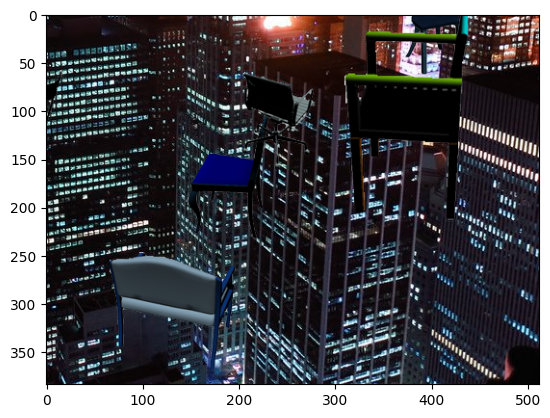

In [62]:
plt.imshow(test_img1.permute(1,2,0).type('torch.LongTensor'))

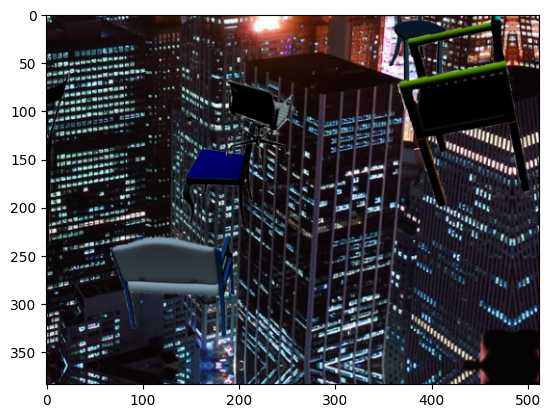

In [63]:
plt.imshow(test_img2.permute(1,2,0).type('torch.LongTensor'))

In [64]:
real_flow = test_dataset[1][1]

In [65]:
flow_to_image(real_flow)

tensor([[[255, 255, 255,  ..., 172, 172, 171],
         [255, 255, 255,  ..., 172, 172, 171],
         [255, 255, 255,  ..., 172, 172, 171],
         ...,
         [222, 222, 222,  ..., 155, 154, 154],
         [222, 222, 222,  ..., 154, 154, 154],
         [222, 222, 222,  ..., 154, 154, 154]],

        [[248, 248, 248,  ..., 248, 248, 248],
         [248, 248, 248,  ..., 248, 248, 248],
         [248, 248, 248,  ..., 248, 248, 248],
         ...,
         [197, 197, 197,  ..., 189, 189, 189],
         [197, 197, 197,  ..., 189, 189, 189],
         [196, 196, 196,  ..., 189, 189, 189]],

        [[240, 241, 241,  ..., 255, 255, 255],
         [241, 241, 241,  ..., 255, 255, 255],
         [241, 241, 241,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)

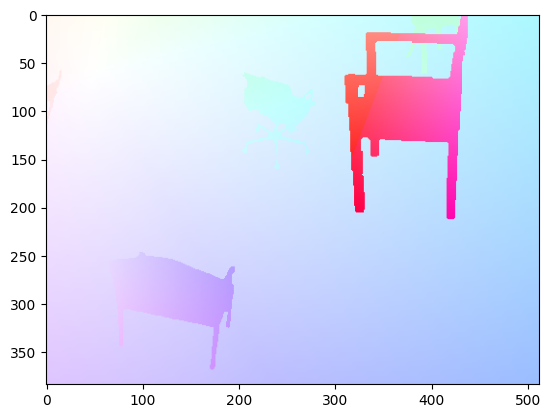

In [66]:
plt.imshow(flow_to_image(real_flow).permute(1,2,0).type('torch.LongTensor'))

In [71]:
%%time
predict_flow = model(test_dataset[1][0].resize(1,6,384,512).to(device))

CPU times: user 17.4 ms, sys: 966 µs, total: 18.4 ms
Wall time: 30.8 ms


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [68]:
predict_flow_inter = F.interpolate(predict_flow, (384,512))

In [69]:
predict_flow_inter[0].size()

torch.Size([2, 384, 512])

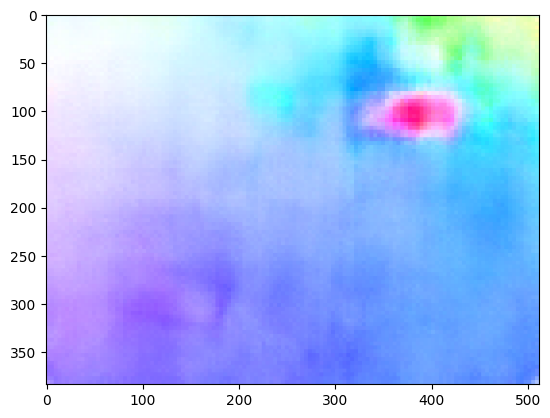

In [70]:
plt.imshow(flow_to_image(predict_flow_inter[0]).permute(1,2,0).type('torch.LongTensor'))

In [48]:
test_dataset[0][0].resize(1,6,384,512).size()

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


torch.Size([1, 6, 384, 512])

In [ ]:
torch.cat((res[0][0][0], res[0][0][1])).size()

torch.Size([6, 384, 512])

In [ ]:
|target = train_dataset[1][1]
h, w = target.size()[-2:]
outputs = [F.interpolate(rrs[0], (h,w)), *rrs[1:]]
# interpolate = F.interpolate(rrs[0], (h,w))

In [ ]:
outputs[2].size()

torch.Size([1, 2, 24, 32])

In [ ]:
type(train_dataset[1][1])

numpy.ndarray

In [ ]:
rrs = model(a)

In [ ]:
rrs[0].shape

torch.Size([1, 2, 96, 128])

In [ ]:
from cv2 import imread

In [ ]:
img = cv2.imread(train_data_pathes[3][0][1]).astype(float)

In [ ]:
train_dataset[0][0][1]

tensor([[[ 12.,  12.,  12.,  ...,  17.,  17.,  17.],
         [ 12.,  12.,  12.,  ...,  17.,  17.,  17.],
         [ 12.,  12.,  12.,  ...,  17.,  17.,  17.],
         ...,
         [ 23.,  21.,  25.,  ..., 120., 138., 166.],
         [ 19.,  17.,  14.,  ..., 222., 215., 217.],
         [ 14.,  18.,  17.,  ..., 177., 169., 181.]],

        [[  6.,   6.,   6.,  ...,   7.,   7.,   7.],
         [  6.,   6.,   6.,  ...,   7.,   7.,   7.],
         [  6.,   6.,   6.,  ...,   7.,   7.,   7.],
         ...,
         [ 13.,  11.,  15.,  ..., 153., 175., 198.],
         [ 15.,  14.,  10.,  ..., 252., 252., 253.],
         [ 13.,  17.,  16.,  ..., 216., 210., 219.]],

        [[  7.,   7.,   7.,  ...,   7.,   7.,   7.],
         [  7.,   7.,   7.,  ...,   7.,   7.,   7.],
         [  7.,   7.,   7.,  ...,   7.,   7.,   7.],
         ...,
         [ 21.,  18.,  24.,  ..., 145., 170., 194.],
         [ 20.,  19.,  16.,  ..., 251., 251., 251.],
         [ 16.,  20.,  20.,  ..., 209., 205., 215.]]]

In [ ]:
train_img[0,0,:]

tensor([69., 99., 94.], dtype=torch.float64)

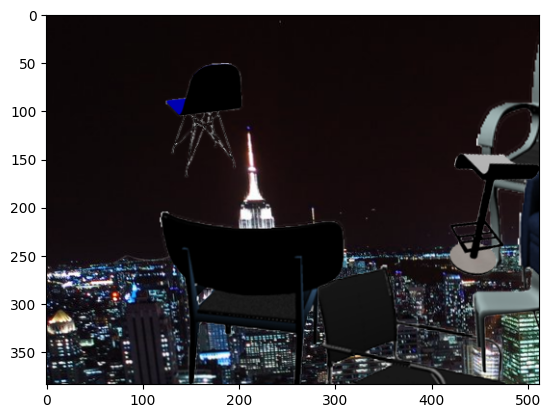

In [ ]:
plt.imshow(train_dataset[0][0][1].permute(1,2,0).type('torch.LongTensor'))